In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX 

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

file_path = './updated_data_with_time.csv'
df = pd.read_csv(file_path)
df


,Country,Continent,Months,Element,Year,TempC,Time
0,Afghanistan,Asia,1,Temperature change,1961,0.745,1961-01-01
1,Pakistan,Asia,1,Temperature change,1961,0.407,1961-01-01
2,Norway,Europe,1,Temperature change,1961,0.362,1961-01-01
3,Nigeria,Africa,1,Temperature change,1961,0.474,1961-01-01
4,Niger,Africa,1,Temperature change,1961,0.382,1961-01-01
...,...,...,...,...,...,...,...
188563,Uruguay,South America,12,Temperature change,2023,0.013,2023-12-01
188564,Cyprus,Asia,12,Temperature change,2023,3.272,2023-12-01
188565,Democratic People's Republic of Korea,Asia,12,Temperature change,2023,0.423,2023-12-01
188566,Canada,North America,12,Temperature change,2023,7.818,2023-12-01


In [2]:
germany = df[(df['Country'] == "Germany")].copy()
germany['Time'] = pd.to_datetime(germany['Time'])
germany = germany.sort_values(by='Time')
germany = germany.set_index('Time',drop=True)
germany.head()

,Country,Continent,Months,Element,Year,TempC
Time,,,,,,
1961-01-01,Germany,Europe,1,Temperature change,1961,-0.204
1961-02-01,Germany,Europe,2,Temperature change,1961,4.187
1961-03-01,Germany,Europe,3,Temperature change,1961,2.758
1961-04-01,Germany,Europe,4,Temperature change,1961,3.224
1961-05-01,Germany,Europe,5,Temperature change,1961,-1.325


In [3]:
ger_sort = germany[['TempC']]
ger_sort

,TempC
Time,
1961-01-01,-0.204
1961-02-01,4.187
1961-03-01,2.758
1961-04-01,3.224
1961-05-01,-1.325
...,...
2023-08-01,2.143
2023-09-01,4.228
2023-10-01,3.175


In [4]:
scaler = MinMaxScaler(feature_range=(-1, 1))

# Chuyển đổi giá trị TempC về khoảng từ -1 đến 1 và cập nhật trực tiếp lên cột TempC
ger_sort['TempC'] = scaler.fit_transform(ger_sort[['TempC']])

# In ra 5 hàng đầu tiên để kiểm tra
print(ger_sort.head())


               TempC
Time                
1961-01-01  0.034036
1961-02-01  0.735698
1961-03-01  0.507351
1961-04-01  0.581815
1961-05-01 -0.145094


C:\Users\VincentPham\AppData\Local\Temp\ipykernel_30312\3270275267.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ger_sort['TempC'] = scaler.fit_transform(ger_sort[['TempC']])


In [5]:
# Calculate Simple Moving Averages (SMA) with different window sizes
ger_sort['SMA_12'] = ger_sort['TempC'].rolling(window=12).mean()

ger_sort['EMA_12'] = ger_sort['TempC'].ewm(span=12, adjust=False).mean()

C:\Users\VincentPham\AppData\Local\Temp\ipykernel_30312\2040153987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ger_sort['SMA_12'] = ger_sort['TempC'].rolling(window=12).mean()
C:\Users\VincentPham\AppData\Local\Temp\ipykernel_30312\2040153987.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ger_sort['EMA_12'] = ger_sort['TempC'].ewm(span=12, adjust=False).mean()


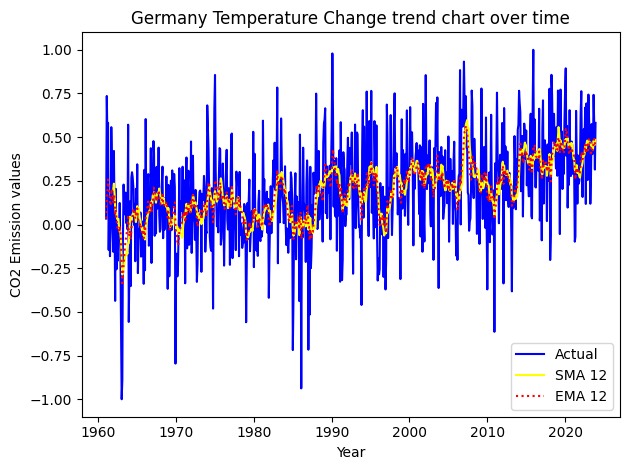

In [6]:
# Vẽ các đường SMA và EMA với màu sắc và kiểu dáng khác nhau
plt.plot(ger_sort['TempC'], label='Actual', color='blue')

plt.plot(ger_sort['SMA_12'], label='SMA 12', color='yellow', linestyle='-')

plt.plot(ger_sort['EMA_12'], label='EMA 12', color='red', linestyle=':')

# Thêm tiêu đề và nhãn trục
plt.title('Germany Temperature Change trend chart over time')
plt.xlabel('Year')
plt.ylabel('CO2 Emission values')

# Thêm chú thích
plt.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

In [7]:
ger_sort = ger_sort[['TempC']]
ger_sort

,TempC
Time,
1961-01-01,0.034036
1961-02-01,0.735698
1961-03-01,0.507351
1961-04-01,0.581815
1961-05-01,-0.145094
...,...
2023-08-01,0.409076
2023-09-01,0.742250
2023-10-01,0.573985


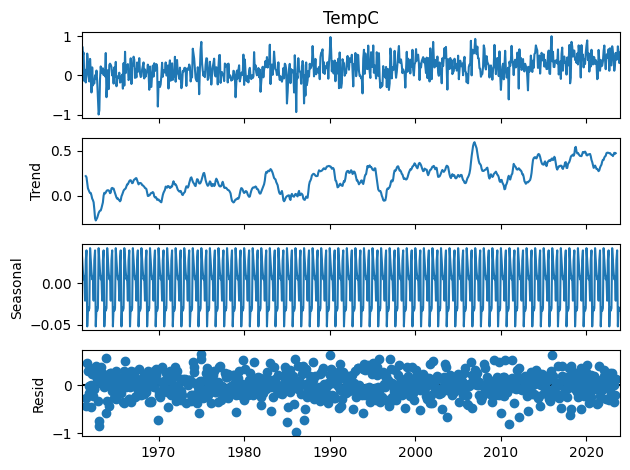

In [8]:
# ETS Decomposition
result = seasonal_decompose(ger_sort['TempC'],
                            model ='additive', period = 12)

# ETS plot
result.plot();


In [9]:
test_size = 0.8
split_index = int(test_size * len(ger_sort))  # 90% for training

# Split the data
train = ger_sort.iloc[:split_index]
test = ger_sort.iloc[split_index:]

train, test

(               TempC
 Time                
 1961-01-01  0.034036
 1961-02-01  0.735698
 1961-03-01  0.507351
 1961-04-01  0.581815
 1961-05-01 -0.145094
 ...              ...
 2010-12-01 -0.614094
 2011-01-01  0.349952
 2011-02-01  0.241131
 2011-03-01  0.356823
 2011-04-01  0.754714
 
 [604 rows x 1 columns],
                TempC
 Time                
 2011-05-01  0.399968
 2011-06-01  0.294183
 2011-07-01  0.007191
 2011-08-01  0.324704
 2011-09-01  0.399329
 ...              ...
 2023-08-01  0.409076
 2023-09-01  0.742250
 2023-10-01  0.573985
 2023-11-01  0.314637
 2023-12-01  0.581655
 
 [152 rows x 1 columns])

In [10]:
# Perform the ADF test on the training data
result = adfuller(train['TempC'])

# Print the test results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpret the results
if result[1] <= 0.05:
    print("Reject the null hypothesis. The time series is stationary.")
else:
    print("Fail to reject the null hypothesis. The time series is non-stationary.")

ADF Statistic: -10.896032
p-value: 0.000000
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Reject the null hypothesis. The time series is stationary.


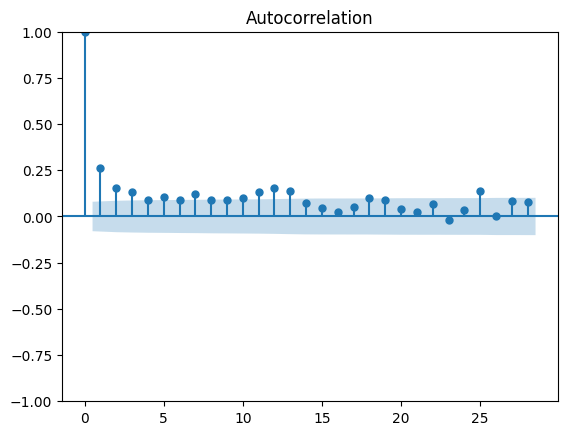

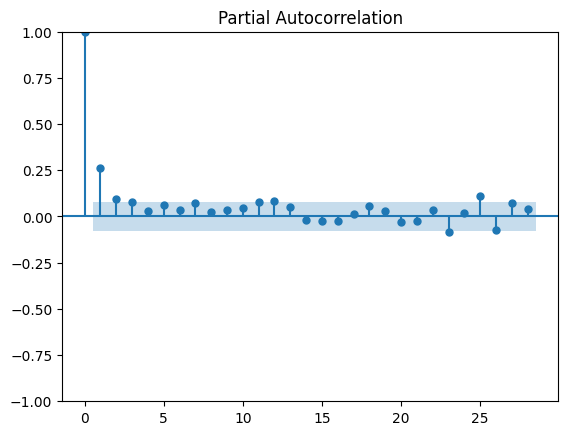

In [11]:
acf_original = plot_acf(train['TempC'])

pacf_original = plot_pacf(train['TempC'])

ARIMA

In [12]:
model = ARIMA(train['TempC'], order = (2,0,2))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\VincentPham\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\VincentPham\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\VincentPham\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  TempC   No. Observations:                  604
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 -68.009
Date:                Mon, 02 Dec 2024   AIC                            148.019
Time:                        12:48:16   BIC                            174.440
Sample:                    01-01-1961   HQIC                           158.301
                         - 04-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1480      0.040      3.704      0.000       0.070       0.226
ar.L1          1.4508      0.210      6.918      0.000       1.040       1.862
ar.L2         -0.4555      0.206     -2.208      0.0

c:\Users\VincentPham\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


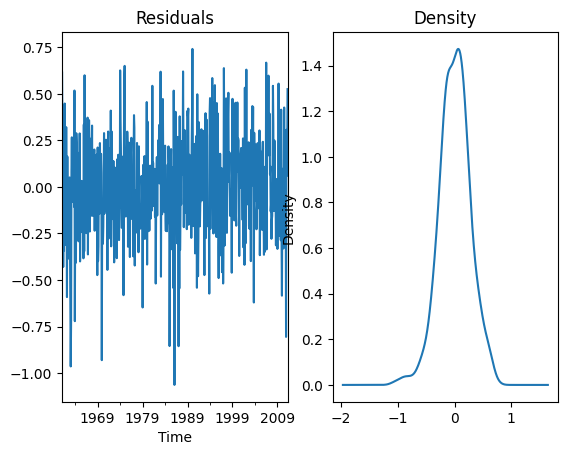

In [13]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

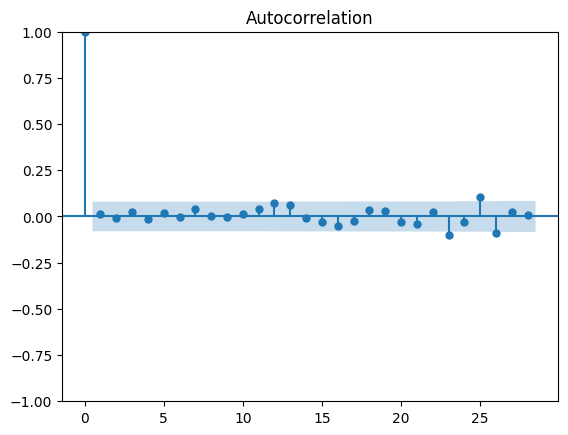

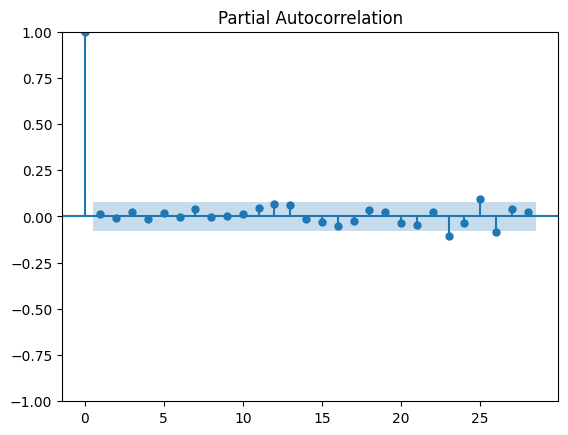

In [14]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

C:\Users\VincentPham\AppData\Local\Temp\ipykernel_30312\1054684106.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ger_sort['forecast_manual'] = [None]*len(train) + list(forecast_test)


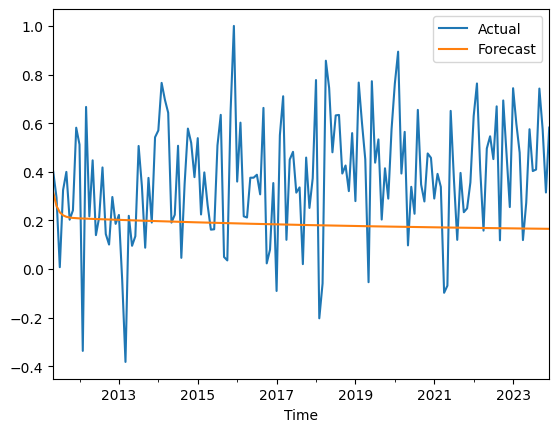

In [16]:
forecast_test = model_fit.forecast(steps=len(test))

ger_sort['forecast_manual'] = [None]*len(train) + list(forecast_test)


# ger_sort.plot()
# test['TempC'].plot()
# ger_sort['forecast_manual'].plot()

test['TempC'].plot(label='Actual')
ger_sort['forecast_manual'].loc[test.index].plot(label='Forecast')
plt.legend()


In [276]:
auto_arima_model = auto_arima(train['TempC'], stepwise=False, seasonal=False)

auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  604
Model:               SARIMAX(0, 1, 4)   Log Likelihood                 -68.078
Date:                Mon, 02 Dec 2024   AIC                            148.157
Time:                        12:06:17   BIC                            174.568
Sample:                    01-01-1961   HQIC                           158.436
                         - 04-01-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.000      1.805      0.071   -3.54e-05       0.001
ma.L1         -0.8233      0.040    -20.808      0.000      -0.901      -0.746
ma.L2         -0.0495      0.054     -0.923      0.356      -0.155       0.056
ma.L3         -0.0518      0.051     -1.022      0.307      -0.151       0.048
ma.L4         -0.0581      0.041     -1.418      0.156      -0.138       0.022
sigma2         0.0728      0.004     19.639      0.000       0.066       0.080
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                20.44
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.28
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Time'>

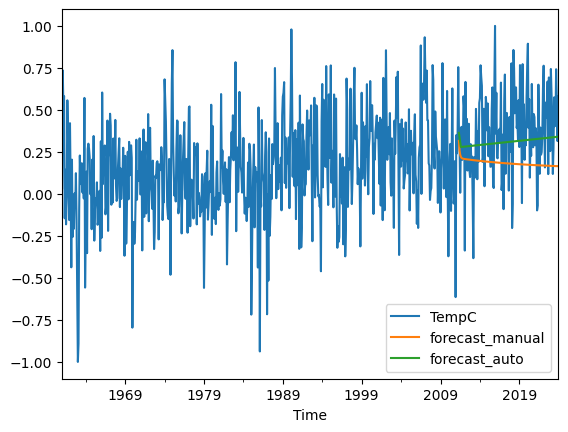

In [277]:
forecast_test_auto = auto_arima_model.predict(n_periods=len(test))
ger_sort['forecast_auto'] = [None]*len(train) + list(forecast_test_auto)

ger_sort.plot()

In [278]:
# Chuyển đổi ngược về giá trị ban đầu từ scaler
train_exp = scaler.inverse_transform(train[['TempC']])
test_exp = scaler.inverse_transform(test[['TempC']])
forecast_test_exp = scaler.inverse_transform(np.array(forecast_test).reshape(-1, 1))
forecast_test_auto_exp = scaler.inverse_transform(np.array(forecast_test_auto).reshape(-1, 1))

In [279]:
"""Performance Metrics for Manual ARIMA"""

mse = mean_squared_error(test_exp, forecast_test_exp)
mae = mean_absolute_error(test_exp, forecast_test_exp)
mape = mean_absolute_percentage_error(test_exp, forecast_test_exp)
rmse = np.sqrt(mean_squared_error(test_exp, forecast_test_exp))
r2 = r2_score(test_exp, forecast_test_exp)

print(f'mse - manual: {mse}')
print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')
print(f'r2 - manual: {r2}')

mse - manual: 3.805856225387481
mae - manual: 1.5911999200479638
mape - manual: 0.9958171316102952
rmse - manual: 1.950860380803168
r2 - manual: -0.6294177061247574


In [280]:
"""Performance Metrics for Auto ARIMA"""

mse = mean_squared_error(test_exp, forecast_test_auto_exp)
mae = mean_absolute_error(test_exp, forecast_test_auto_exp)
mape = mean_absolute_percentage_error(test_exp, forecast_test_auto_exp)
rmse = np.sqrt(mean_squared_error(test_exp, forecast_test_auto_exp))
r2 = r2_score(test_exp, forecast_test_auto_exp)

print(f'mse - auto: {mse}')
print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')
print(f'r2 - auto: {r2}')


mse - auto: 2.430782402982005
mae - auto: 1.245146093073044
mape - auto: 1.300733493319101
rmse - auto: 1.5590966624882516
r2 - auto: -0.04070139611017809


In [281]:
ger_sort.tail()

,TempC,forecast_manual,forecast_auto
Time,,,
2023-08-01,0.409076,0.165751,0.338849
2023-09-01,0.742250,0.165596,0.339262
2023-10-01,0.573985,0.165443,0.339674
2023-11-01,0.314637,0.165291,0.340087
2023-12-01,0.581655,0.165141,0.340499


SARIMA

In [282]:
germany = germany.drop(['Country', 'Element','Continent','Months','Year'], axis=1)
germany.head()

,TempC
Time,
1961-01-01,-0.204
1961-02-01,4.187
1961-03-01,2.758
1961-04-01,3.224
1961-05-01,-1.325


In [283]:
scaler = MinMaxScaler(feature_range=(-1, 1))

# Chuyển đổi giá trị TempC về khoảng từ -1 đến 1 và cập nhật trực tiếp lên cột TempC
germany['TempC'] = scaler.fit_transform(germany[['TempC']])

# In ra 5 hàng đầu tiên để kiểm tra
print(germany.head())


               TempC
Time                
1961-01-01  0.034036
1961-02-01  0.735698
1961-03-01  0.507351
1961-04-01  0.581815
1961-05-01 -0.145094


In [284]:
auto_arima_final = auto_arima(germany['TempC'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.24 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=638.865, Time=0.22 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=443.615, Time=1.53 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.47 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=636.977, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=627.541, Time=0.15 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=378.686, Time=4.25 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=11.33 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=4.27 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=398.135, Time=2.18 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=379.384, Time=2.96 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=377.237, Time=4.91 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=441.047, Time=1.86 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=10.69 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Tim

In [285]:
auto_arima_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  756
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood                -182.892
Date:                             Mon, 02 Dec 2024   AIC                            375.784
Time:                                     12:08:05   BIC                            398.844
Sample:                                 01-01-1961   HQIC                           384.673
                                      - 12-01-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6398      0.154      4.145      0.000       0.337       0.942
ma.L1         -0.4949      0.170     -2.906      0.004      -0.829      -0.161
ar.S.L12      -0.6162      0.032    -19.554      0.000      -0.678      -0.554
ar.S.L24      -0.2978      0.031     -9.623      0.000      -0.358      -0.237
sigma2         0.0950      0.004     21.712      0.000       0.086       0.104
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                16.16
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.13
Prob(H) (two-sided):                  0.91   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [286]:
# Trích xuất các tham số order và seasonal_order
best_order = auto_arima_final.order  # (p, d, q)
best_seasonal_order = auto_arima_final.seasonal_order  # (P, D, Q, s)

print(f"Best ARIMA order: {best_order}")
print(f"Best Seasonal Order: {best_seasonal_order}")

Best ARIMA order: (1, 0, 1)
Best Seasonal Order: (2, 1, 0, 12)


In [287]:
sarimax_model = SARIMAX(train['TempC'],  
                order = best_order,  
                seasonal_order = best_seasonal_order) 

result = sarimax_model.fit() 
result.summary() 

c:\Users\VincentPham\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\VincentPham\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               TempC   No. Observations:                  604
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood                -155.668
Date:                             Mon, 02 Dec 2024   AIC                            321.335
Time:                                     12:08:07   BIC                            343.253
Sample:                                 01-01-1961   HQIC                           329.873
                                      - 04-01-2011                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5956      0.177      3.366      0.001       0.249       0.942
ma.L1         -0.4309      0.194     -2.217      0.027      -0.812      -0.050
ar.S.L12      -0.5700      0.036    -15.881      0.000      -0.640      -0.500
ar.S.L24      -0.2862      0.034     -8.305      0.000      -0.354      -0.219
sigma2         0.0983      0.005     19.341      0.000       0.088       0.108
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                12.84
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.12
Prob(H) (two-sided):                  0.91   Kurtosis:                         3.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\Users\VincentPham\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


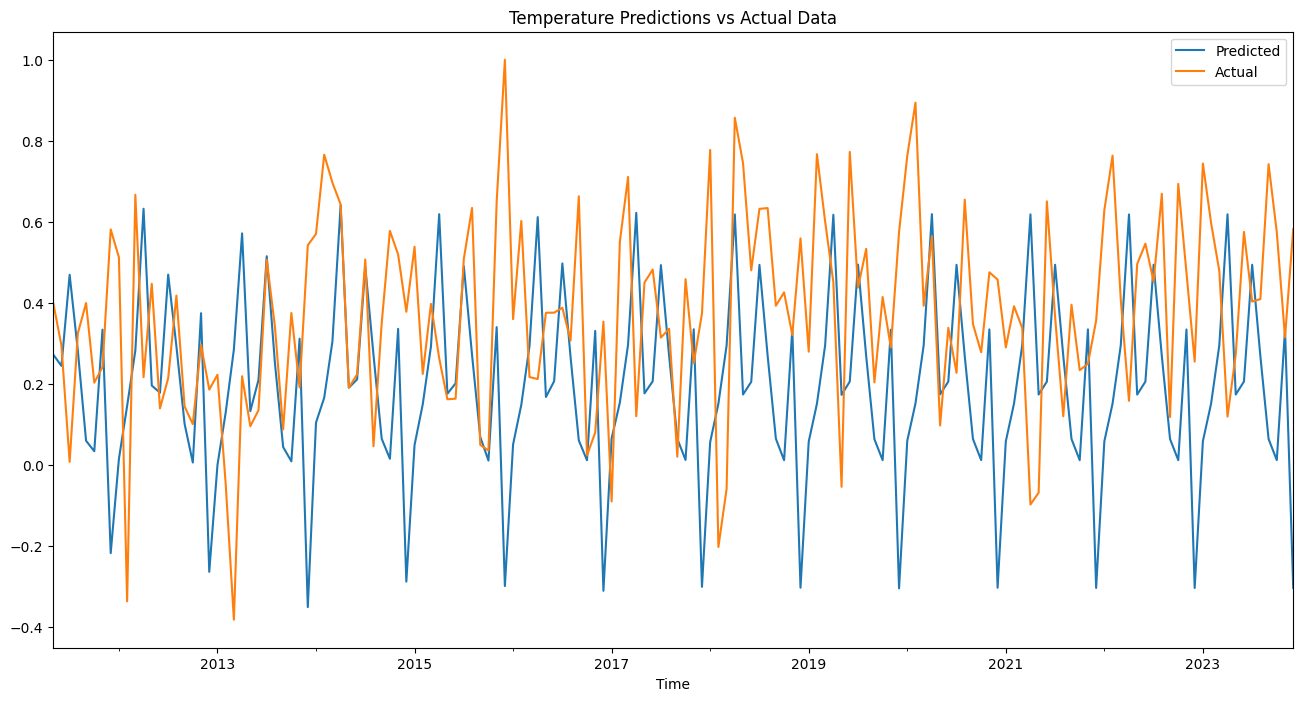

In [288]:
start = len(train) 
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
plt.figure(figsize=(16, 8))
predictions.plot(label='Predicted', legend = True) 
test['TempC'].plot(label='Actual', legend = True)
plt.legend()

plt.title('Temperature Predictions vs Actual Data') 

plt.show()

In [289]:
train_exp = scaler.inverse_transform(train[['TempC']])
test_exp = scaler.inverse_transform(test[['TempC']])
predictions_exp = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

In [290]:
"""Performance Metrics for SARIMAX"""

mse = mean_squared_error(test_exp, predictions)
mae = mean_absolute_error(test_exp, predictions)
mape = mean_absolute_percentage_error(test_exp, predictions)
rmse = np.sqrt(mean_squared_error(test_exp, predictions))
r2 = r2_score(test_exp, predictions_exp)

print(f'mse: {mse}')
print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')
print(f'r2 score: {r2}')

mse: 5.427486431165964
mae: 1.9515675086370643
mape: 0.9316203127120728
rmse: 2.3296966393000536
r2 score: -1.5782387569416216


In [291]:
germany['TempC'] = list(train_exp.flatten()) + list(test_exp.flatten())

In [292]:
model = ExponentialSmoothing(train['TempC'], trend='add', seasonal='add')
fitted_model = model.fit()

# Dự đoán giá trị trên tập test
es_predictions = fitted_model.forecast(len(test))


c:\Users\VincentPham\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


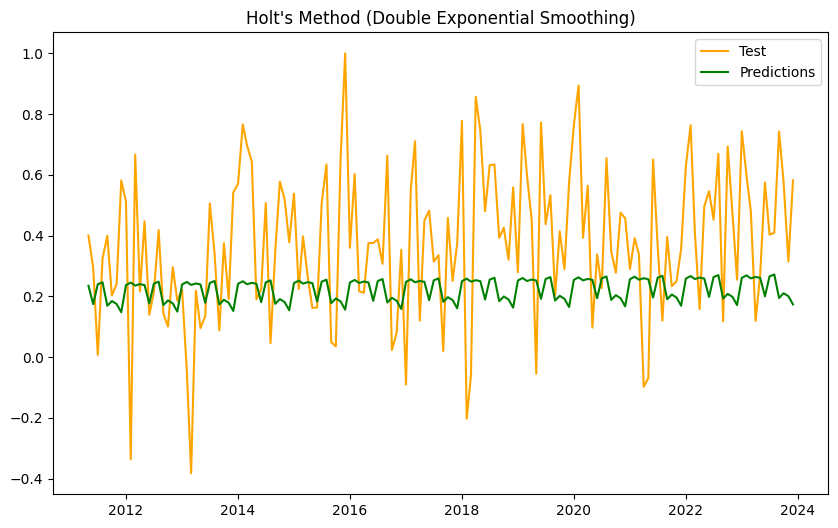

In [293]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
# plt.plot(ger_sort.index, ger_sort['TempC'], label='Actual')
plt.plot(test.index, test['TempC'], label='Test', color='orange')
plt.plot(test.index, es_predictions, label='Predictions', color='green')
plt.legend()
plt.title("Holt's Method (Double Exponential Smoothing)")
plt.show()

In [294]:
train_exp = scaler.inverse_transform(train[['TempC']])
test_exp = scaler.inverse_transform(test[['TempC']])
es_predictions_exp = scaler.inverse_transform(np.array(es_predictions).reshape(-1, 1))

In [295]:
##Performance Metrics for Exponential Smoothing

# Tính các metrics trên giá trị gốc (original scale)
mae_original = mean_absolute_error(test_exp, es_predictions_exp)
mape_original = mean_absolute_percentage_error(test_exp, es_predictions_exp)
mse_original = mean_squared_error(test_exp, es_predictions_exp)
rmse_original = np.sqrt(mse_original)
r2_original = r2_score(test_exp, es_predictions_exp)

# Hiển thị các metrics
print(f"Mean Absolute Error (MAE) - Original Scale: {mae_original}")
print(f"Mean Absolute Percentage Error (MAPE) - Original Scale: {mape_original * 100:.2f}%")
print(f"Mean Squared Error (MSE) - Original Scale: {mse_original}")
print(f"Root Mean Squared Error (RMSE) - Original Scale: {rmse_original}")
print(f"R-squared (R2) - Original Scale: {r2_original}")

Mean Absolute Error (MAE) - Original Scale: 1.4641837215078797
Mean Absolute Percentage Error (MAPE) - Original Scale: 102.67%
Mean Squared Error (MSE) - Original Scale: 3.250777451596898
Root Mean Squared Error (RMSE) - Original Scale: 1.802991251114907
R-squared (R2) - Original Scale: -0.3917694270659997
